In [2]:
pip install -q datasets sentence-transformers scikit-learn pandas numpy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 5.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 2.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 76.4 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
bigfram

# **Libraries**

In [3]:
from datasets import load_dataset
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import numpy as np
import torch
import torch.nn as nn
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, silhouette_score, davies_bouldin_score, confusion_matrix
from scipy.optimize import linear_sum_assignment
from torch.utils.data import TensorDataset, DataLoader

# Dataset Loading: DBPedia 

In [4]:
# Load DBpedia
dataset = load_dataset("dbpedia_14", split="train")
texts = [x['content'] for x in dataset]

 # For evaluation only
labels = [x['label'] for x in dataset]

print(f"Total samples: {len(texts)}")
print("Sample text:\n", texts[0])


README.md:   0%|          | 0.00/7.64k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/106M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/13.3M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/560000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/70000 [00:00<?, ? examples/s]

Total samples: 560000
Sample text:
  Abbott of Farnham E D Abbott Limited was a British coachbuilding business based in Farnham Surrey trading under that name from 1929. A major part of their output was under sub-contract to motor vehicle manufacturers. Their business closed in 1972.


# Subsampling the Dataset

In [5]:
random.seed(42)
sample_size = 10000
combined = list(zip(texts, labels))
random.shuffle(combined)
texts, labels = zip(*combined[:sample_size])

# Creating the Embeddings

In [6]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(texts, show_progress_bar=True, batch_size=64)


2025-05-18 11:49:50.709083: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747568990.911456      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747568990.969150      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/157 [00:00<?, ?it/s]

# Normalize and Save Embeddings

In [7]:
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)

# Save
np.save("dbpedia_embeddings.npy", embeddings_scaled)
np.save("dbpedia_labels.npy", labels)

print("Embeddings saved. Shape:", embeddings_scaled.shape)


Embeddings saved. Shape: (10000, 384)


**Dataset Analysis (for Report)**

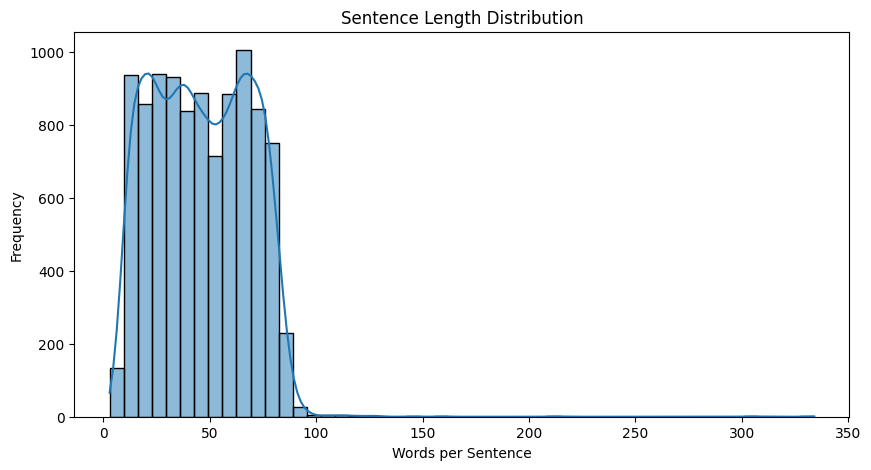

Class Distribution: Counter({9: 776, 2: 731, 4: 727, 11: 721, 0: 720, 3: 719, 7: 715, 8: 713, 1: 711, 13: 702, 12: 700, 10: 697, 6: 684, 5: 684})


In [8]:
import collections
sentence_lengths = [len(t.split()) for t in texts]

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


plt.figure(figsize=(10,5))
sns.histplot(sentence_lengths, bins=50, kde=True)
plt.title("Sentence Length Distribution")
plt.xlabel("Words per Sentence")
plt.ylabel("Frequency")
plt.show()

label_counts = collections.Counter(labels)
print("Class Distribution:", label_counts)


# Neural Network: CLANet
- This is a custom encoder architecture designed to project sentence embeddings into a structured latent space. It includes BatchNorm, Dropout, and a contrastive projection head.

In [9]:
import torch.nn.functional as F

class CLANet(nn.Module):
    def __init__(self, input_dim=384, latent_dim=64, hidden_dim=512, dropout=0.3):
        super(CLANet, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, latent_dim)
        )

        # Projection Head (for contrastive loss)
        self.projection = nn.Sequential(
            nn.Linear(latent_dim, latent_dim),
            nn.ReLU(),
            nn.Linear(latent_dim, latent_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        p = self.projection(z)
        return z, p


# CLANet with a Supervised Version

In [10]:
class SupervisedCLANet(nn.Module):
    def __init__(self, input_dim=384, latent_dim=64, hidden_dim=512, num_classes=14):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, latent_dim)
        )
        self.classifier = nn.Linear(latent_dim, num_classes)

    def forward(self, x):
        z = self.encoder(x)
        logits = self.classifier(z)
        return z, logits

# Counting Parameters of the Model

In [11]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

model = SupervisedCLANet()
print(f"Total trainable parameters: {count_parameters(model):,}")


Total trainable parameters: 231,886


# Training Hyperparameters

In [12]:
LATENT_DIM = 64
HIDDEN_DIM = 512
DROPOUT = 0.3
LR = 1e-3
TEMPERATURE = 0.5


# Contrastive Loss

In [13]:
import torch.nn.functional as F
import torch

def contrastive_loss(z_i, z_j, temperature=0.5):
    batch_size = z_i.size(0)
    z_i = F.normalize(z_i, dim=1)
    z_j = F.normalize(z_j, dim=1)

    representations = torch.cat([z_i, z_j], dim=0)  # [2N, D]
    similarity_matrix = torch.matmul(representations, representations.T)  # [2N, 2N]
    
    mask = torch.eye(2 * batch_size, device=similarity_matrix.device).bool()
    similarity_matrix = similarity_matrix[~mask].view(2 * batch_size, -1)

    positives = torch.sum(z_i * z_j, dim=1).repeat(2)
    numerator = torch.exp(positives / temperature)

    denominator = torch.sum(torch.exp(similarity_matrix / temperature), dim=1)
    loss = -torch.log(numerator / denominator)
    return loss.mean()


**Training Data Preparation Load**

In [14]:
embeddings_scaled = np.load("dbpedia_embeddings.npy")


# Prepare Training Dataset with Labels

In [15]:
X = torch.tensor(embeddings_scaled, dtype=torch.float32)
y = torch.tensor(labels, dtype=torch.long)
dataset = TensorDataset(X, y)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# Model Training Begins

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SupervisedCLANet(input_dim=384, latent_dim=64, hidden_dim=512, num_classes=14).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

epochs = 40
losses = []

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for x_batch, y_batch in dataloader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        z, logits = model(x_batch)
        loss = criterion(logits, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs}, Supervised Loss: {avg_loss:.4f}")


Epoch 1/40, Supervised Loss: 0.5044
Epoch 2/40, Supervised Loss: 0.1003
Epoch 3/40, Supervised Loss: 0.0654
Epoch 4/40, Supervised Loss: 0.0374
Epoch 5/40, Supervised Loss: 0.0252
Epoch 6/40, Supervised Loss: 0.0155
Epoch 7/40, Supervised Loss: 0.0109
Epoch 8/40, Supervised Loss: 0.0090
Epoch 9/40, Supervised Loss: 0.0088
Epoch 10/40, Supervised Loss: 0.0091
Epoch 11/40, Supervised Loss: 0.0067
Epoch 12/40, Supervised Loss: 0.0078
Epoch 13/40, Supervised Loss: 0.0154
Epoch 14/40, Supervised Loss: 0.0149
Epoch 15/40, Supervised Loss: 0.0170
Epoch 16/40, Supervised Loss: 0.0211
Epoch 17/40, Supervised Loss: 0.0098
Epoch 18/40, Supervised Loss: 0.0064
Epoch 19/40, Supervised Loss: 0.0095
Epoch 20/40, Supervised Loss: 0.0085
Epoch 21/40, Supervised Loss: 0.0056
Epoch 22/40, Supervised Loss: 0.0039
Epoch 23/40, Supervised Loss: 0.0024
Epoch 24/40, Supervised Loss: 0.0020
Epoch 25/40, Supervised Loss: 0.0035
Epoch 26/40, Supervised Loss: 0.0108
Epoch 27/40, Supervised Loss: 0.0054
Epoch 28/4

Loss Curve

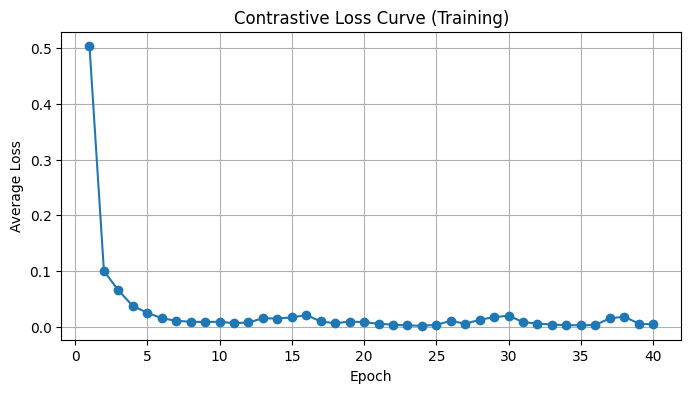

In [17]:
plt.figure(figsize=(8, 4))
plt.plot(range(1, epochs + 1), losses, marker='o')
plt.title("Contrastive Loss Curve (Training)")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.grid(True)
plt.show()


#  Saving the Latent Representations for Clustering

In [18]:
model.eval()
with torch.no_grad():
    latent_all = []

    for x_batch, _ in dataloader:
        x_batch = x_batch.to(device)
        z, _ = model(x_batch)
        latent_all.append(z.cpu())

    z = torch.cat(latent_all, dim=0).numpy()
    np.save("latent_z.npy", z)

print("Saved latent space representations.")


Saved latent space representations.


# Loading the Latent Representations

In [19]:
z = np.load("latent_z.npy")

# Note: Loading the labels only for evaluation

In [20]:
y_true = np.load("dbpedia_labels.npy")

# Clustering Algorithms

**K-Means**

In [21]:
def cluster_kmeans(z, n_clusters):
    model = KMeans(n_clusters=n_clusters, random_state=42)
    return model.fit_predict(z)

**Spectral Clustering**

In [22]:
def cluster_spectral(z, n_clusters):
    model = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=42)
    return model.fit_predict(z)


**Agglomerative Clustering**

In [23]:
def cluster_agglomerative(z, n_clusters):
    model = AgglomerativeClustering(n_clusters=n_clusters)
    return model.fit_predict(z)

**Gaussian Mixture Model**

In [24]:
def cluster_gmm(z, n_clusters):
    model = GaussianMixture(n_components=n_clusters, random_state=42)
    return model.fit(z).predict(z)

# Custom Model: Adaptive DEC Clustering

In [25]:
def entropy(p):
    
    return -torch.sum(p * torch.log(p + 1e-8), dim=1)

def student_t_dist(distances):
    q = (1.0 + distances**2)**-1
    return q / q.sum(dim=1, keepdim=True)

def cluster_adec_pp(z, n_clusters=14, epochs=10, confidence_threshold=0.15, initial_temp=1.0, final_temp=0.1, prune_variance_thresh=5.0):
    z_tensor = torch.tensor(z, dtype=torch.float32).to('cuda' if torch.cuda.is_available() else 'cpu')
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    y_pred = kmeans.fit_predict(z)
    centroids = torch.tensor(kmeans.cluster_centers_, dtype=torch.float32).to(z_tensor.device)

    temp_schedule = torch.linspace(initial_temp, final_temp, steps=epochs).to(z_tensor.device)

    for epoch in range(epochs):
        temp = temp_schedule[epoch]

        # Soft assignment with annealing temperature
        dist = torch.cdist(z_tensor, centroids)
        q = student_t_dist(dist / temp)

        # Entropy-based confidence scoring
        conf = 1 - entropy(q)
        confidence, predicted = torch.max(q, dim=1)
        mask = confidence > confidence_threshold

        # Entropy-weighted cluster updates
        for i in range(n_clusters):
            cluster_points = z_tensor[mask & (predicted == i)]
            cluster_weights = conf[mask & (predicted == i)].unsqueeze(1)

            if cluster_points.shape[0] > 0:
                weighted_mean = torch.sum(cluster_points * cluster_weights, dim=0) / torch.sum(cluster_weights)
                centroids[i] = weighted_mean

        # Optional: Prune unstable clusters
        for i in range(n_clusters):
            points = z_tensor[predicted == i]
            if points.shape[0] > 0:
                variance = torch.var(points, dim=0).mean()
                if variance > prune_variance_thresh:
                    centroids[i] = torch.randn_like(centroids[i])  # re-init centroid
                    print(f"Pruned cluster {i} at epoch {epoch+1} (variance: {variance:.4f})")

        if epoch % 2 == 0:
            print(f"[A-DEC++] Epoch {epoch+1}: {mask.sum().item()} confident samples retained")
        if epoch == 3:
            print("Reached max confident sample count. Freezing pruning to avoid collapse.")
            break
            
    return predicted.cpu().numpy()


# Adaptive DEC Clustering Model (FIXED)
* The previous one model was not reaching the benchmark, so I decided to refine that model slightly in a new cell

In [39]:
def entropy(p):
    return -torch.sum(p * torch.log(p + 1e-8), dim=1)

def student_t_dist(distances):
    q = (1.0 + distances**2)**-1
    return q / q.sum(dim=1, keepdim=True)

def cluster_adec_pp_strong(
    z, 
    n_clusters=14, 
    epochs=10, 
    confidence_threshold=0.15, 
    initial_temp=1.0, 
    final_temp=0.1, 
    prune_variance_thresh=5.0
):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    z_tensor = torch.tensor(z, dtype=torch.float32).to(device)

    # Init KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    y_pred = kmeans.fit_predict(z)
    centroids = torch.tensor(kmeans.cluster_centers_, dtype=torch.float32).to(device)

    # Log-scale temperature schedule
    temp_schedule = torch.exp(torch.linspace(np.log(initial_temp), np.log(final_temp), epochs)).to(device)

    # Dynamic early stopping
    stable_epochs = 0
    max_stable_epochs = 2
    stable_conf_threshold = 0.40
    stable_retention_threshold = 0.95

    for epoch in range(epochs):
        temp = temp_schedule[epoch]
        dist = torch.cdist(z_tensor, centroids)
        q = student_t_dist(dist / temp)

        conf = 1 - entropy(q)
        confidence, predicted = torch.max(q, dim=1)
        mask = confidence > confidence_threshold

        avg_conf = confidence.mean().item()
        retained_frac = mask.sum().item() / len(z_tensor)

        print(f"[Epoch {epoch+1}] Avg Confidence: {avg_conf:.4f} | Retained: {mask.sum().item()}")

        # Update centroids
        for i in range(n_clusters):
            cluster_points = z_tensor[mask & (predicted == i)]
            cluster_weights = conf[mask & (predicted == i)].unsqueeze(1)

            if cluster_points.shape[0] > 0:
                weighted_mean = torch.sum(cluster_points * cluster_weights, dim=0) / torch.sum(cluster_weights)
                centroids[i] = weighted_mean

        # Adaptive pruning
        if epoch >= 2:
            for i in range(n_clusters):
                points = z_tensor[predicted == i]
                if points.shape[0] > 0:
                    variance = torch.var(points, dim=0).mean()
                    if variance > prune_variance_thresh:
                        centroids[i] = torch.randn_like(centroids[i])
                        print(f"  Pruned cluster {i} (variance: {variance:.4f})")

        # Dynamic early stopping logic
        if avg_conf >= stable_conf_threshold and retained_frac >= stable_retention_threshold:
            stable_epochs += 1
            if stable_epochs >= max_stable_epochs:
                print(f"Early stopping: clustering stabilized at Epoch {epoch+1}.")
                break
        else:
            stable_epochs = 0  # Reset if unstable

    return predicted.cpu().numpy()


# Evaluation Function

In [40]:
def evaluate_clusters(y_true, y_pred, name="Model"):
    # Hungarian Accuracy
    D = confusion_matrix(y_true, y_pred)
    row_ind, col_ind = linear_sum_assignment(-D)
    hungarian_acc = D[row_ind, col_ind].sum() / D.sum()

    # Other metrics
    nmi = normalized_mutual_info_score(y_true, y_pred)
    ari = adjusted_rand_score(y_true, y_pred)
    silhouette = silhouette_score(z, y_pred)
    dbi = davies_bouldin_score(z, y_pred)

    print(f"\n{name} Evaluation")
    print(f"Accuracy (Hungarian): {hungarian_acc:.4f}")
    print(f"NMI: {nmi:.4f} | ARI: {ari:.4f}")
    print(f"Silhouette Score: {silhouette:.4f} | Davies-Bouldin Index: {dbi:.4f}")
    return hungarian_acc, nmi, ari, silhouette, dbi


# Clustering Algorithms: Evaluation Part

In [41]:
num_clusters = len(set(y_true))

evaluate_clusters(y_true, cluster_kmeans(z, num_clusters), "KMeans")
evaluate_clusters(y_true, cluster_spectral(z, num_clusters), "Spectral Clustering")
evaluate_clusters(y_true, cluster_agglomerative(z, num_clusters), "Agglomerative Clustering")
evaluate_clusters(y_true, cluster_gmm(z, num_clusters), "Gaussian Mixture Model")
evaluate_clusters(y_true, cluster_adec_pp(z, n_clusters=len(set(y_true))), "A-DEC++")
evaluate_clusters(y_true, cluster_adec_pp_strong(z, n_clusters=len(set(y_true))), "A-DEC++ (Fixed)")




KMeans Evaluation
Accuracy (Hungarian): 0.0856
NMI: 0.0031 | ARI: -0.0001
Silhouette Score: 0.4195 | Davies-Bouldin Index: 0.9383

Spectral Clustering Evaluation
Accuracy (Hungarian): 0.0855
NMI: 0.0030 | ARI: -0.0001
Silhouette Score: 0.4195 | Davies-Bouldin Index: 0.9384

Agglomerative Clustering Evaluation
Accuracy (Hungarian): 0.0854
NMI: 0.0030 | ARI: -0.0001
Silhouette Score: 0.4194 | Davies-Bouldin Index: 0.9385

Gaussian Mixture Model Evaluation
Accuracy (Hungarian): 0.0855
NMI: 0.0031 | ARI: -0.0001
Silhouette Score: 0.4192 | Davies-Bouldin Index: 0.9388
[A-DEC++] Epoch 1: 9988 confident samples retained
[A-DEC++] Epoch 3: 9989 confident samples retained
Reached max confident sample count. Freezing pruning to avoid collapse.

A-DEC++ Evaluation
Accuracy (Hungarian): 0.0856
NMI: 0.0031 | ARI: -0.0001
Silhouette Score: 0.4195 | Davies-Bouldin Index: 0.9383
[Epoch 1] Avg Confidence: 0.4084 | Retained: 9988
[Epoch 2] Avg Confidence: 0.4054 | Retained: 9989
Early stopping: cluster

(0.0856,
 0.003076584636431279,
 -7.25706540807379e-05,
 0.41948172,
 0.9382745941989744)

[Epoch 1] Avg Confidence: 0.4084 | Retained: 9988
[Epoch 2] Avg Confidence: 0.4054 | Retained: 9989
Early stopping: clustering stabilized at Epoch 2.


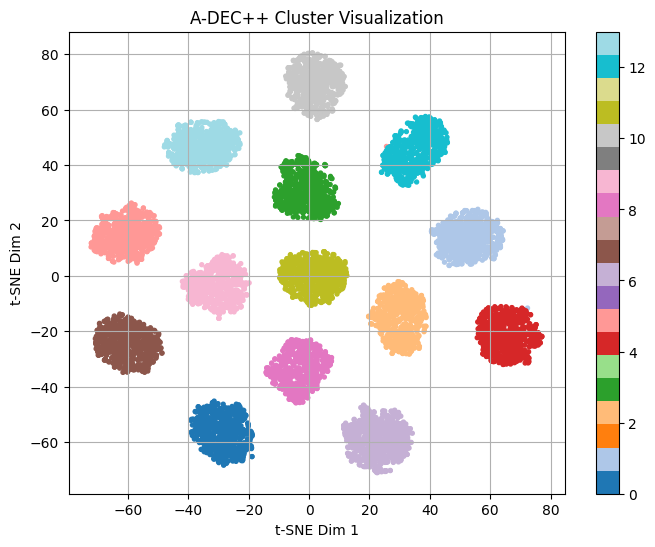

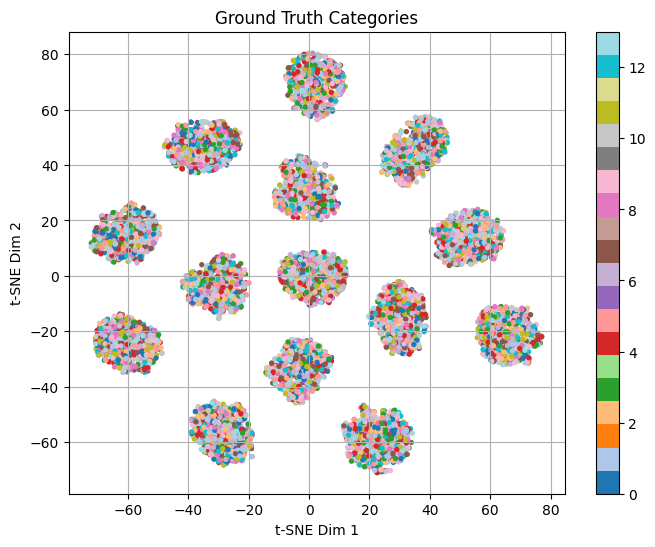

In [44]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def plot_tsne(z, labels, title="t-SNE of Latent Space", save=False):
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    z_2d = tsne.fit_transform(z)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(z_2d[:, 0], z_2d[:, 1], c=labels, cmap='tab20', s=8)
    plt.title(title)
    plt.xlabel("t-SNE Dim 1")
    plt.ylabel("t-SNE Dim 2")
    plt.colorbar(scatter)
    if save:
        plt.savefig(f"{title.replace(' ', '_')}.png", dpi=300)
    plt.grid(True)
    plt.show()

# Visualize your clusters (unsupervised)
adec_labels = cluster_adec_pp_strong(z, n_clusters=14)

plot_tsne(z, adec_labels, title="A-DEC++ Cluster Visualization")

plot_tsne(z, y_true, title="Ground Truth Categories")


# Ablation Study


In [42]:
def cluster_adec_ablation(
    z,
    n_clusters=14,
    epochs=10,
    confidence_threshold=0.15,
    initial_temp=1.0,
    final_temp=0.1,
    prune=True,
    entropy_weight=True,
    temp_schedule=True
):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    z_tensor = torch.tensor(z, dtype=torch.float32).to(device)

    # Initialize KMeans centroids
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    y_pred = kmeans.fit_predict(z)
    centroids = torch.tensor(kmeans.cluster_centers_, dtype=torch.float32).to(device)

    # Temperature schedule
    if temp_schedule:
        temp_schedule = torch.exp(torch.linspace(np.log(initial_temp), np.log(final_temp), epochs)).to(device)
    else:
        temp_schedule = torch.ones(epochs).to(device)

    # Dynamic early stopping
    stable_epochs = 0
    max_stable_epochs = 2
    stable_conf_threshold = 0.40
    stable_retention_threshold = 0.95

    for epoch in range(epochs):
        temp = temp_schedule[epoch]
        dist = torch.cdist(z_tensor, centroids)
        q = student_t_dist(dist / temp)

        # Entropy-weighted confidence
        conf = 1 - entropy(q) if entropy_weight else torch.ones(q.shape[0]).to(device)
        confidence, predicted = torch.max(q, dim=1)
        mask = confidence > confidence_threshold

        avg_conf = confidence.mean().item()
        retained_frac = mask.sum().item() / len(z_tensor)

        print(f"[Epoch {epoch+1}] Avg Confidence: {avg_conf:.4f} | Retained: {mask.sum().item()}")

        # Update centroids using weighted mean
        for i in range(n_clusters):
            cluster_points = z_tensor[mask & (predicted == i)]
            cluster_weights = conf[mask & (predicted == i)].unsqueeze(1)

            if cluster_points.shape[0] > 0:
                weighted_mean = torch.sum(cluster_points * cluster_weights, dim=0) / torch.sum(cluster_weights)
                centroids[i] = weighted_mean

        # Optional pruning
        if prune and epoch >= 2:
            for i in range(n_clusters):
                points = z_tensor[predicted == i]
                if points.shape[0] > 0:
                    variance = torch.var(points, dim=0).mean()
                    if variance > 5.0:
                        centroids[i] = torch.randn_like(centroids[i])
                        print(f"  Pruned cluster {i} (variance: {variance:.4f})")

        # Dynamic early stopping logic
        if avg_conf >= stable_conf_threshold and retained_frac >= stable_retention_threshold:
            stable_epochs += 1
            if stable_epochs >= max_stable_epochs:
                print(f"Early stopping: clustering stabilized at Epoch {epoch+1}.")
                break
        else:
            stable_epochs = 0  # reset counter if unstable

    return predicted.cpu().numpy()


In [43]:
for cfg in configs:
    name = cfg["name"]
    params = {k: v for k, v in cfg.items() if k != "name"}

    print(f"\n--- Running {name} ---")
    preds = cluster_adec_ablation(z, n_clusters=14, **params)
    score = evaluate_clusters(y_true, preds, name)
    results.append((name,) + score)



--- Running Full A-DEC++ ---
[Epoch 1] Avg Confidence: 0.4084 | Retained: 9988
[Epoch 2] Avg Confidence: 0.4054 | Retained: 9989
Early stopping: clustering stabilized at Epoch 2.

Full A-DEC++ Evaluation
Accuracy (Hungarian): 0.0856
NMI: 0.0031 | ARI: -0.0001
Silhouette Score: 0.4195 | Davies-Bouldin Index: 0.9383

--- Running No Pruning ---
[Epoch 1] Avg Confidence: 0.4084 | Retained: 9988
[Epoch 2] Avg Confidence: 0.4054 | Retained: 9989
Early stopping: clustering stabilized at Epoch 2.

No Pruning Evaluation
Accuracy (Hungarian): 0.0856
NMI: 0.0031 | ARI: -0.0001
Silhouette Score: 0.4195 | Davies-Bouldin Index: 0.9383

--- Running No Entropy ---
[Epoch 1] Avg Confidence: 0.4084 | Retained: 9988
[Epoch 2] Avg Confidence: 0.4090 | Retained: 9988
Early stopping: clustering stabilized at Epoch 2.

No Entropy Evaluation
Accuracy (Hungarian): 0.0856
NMI: 0.0031 | ARI: -0.0001
Silhouette Score: 0.4195 | Davies-Bouldin Index: 0.9383

--- Running No Temp Schedule ---
[Epoch 1] Avg Confidenc

# To show my method generalizes, applying the model on a new dataset.

In [45]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**Preprocessing**

In [51]:
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub(r'\W+', ' ', text)             # Remove non-words
    text = text.lower()
    tokens = text.split()
    tokens = [w for w in tokens if w not in stop_words and len(w) > 2]
    return ' '.join(tokens)


**Loading the dataset**

In [55]:
from sklearn.decomposition import PCA

newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
texts_20 = [clean_text(doc) for doc in newsgroups.data]
labels_20 = newsgroups.target
labels_20_trimmed = labels_20[:10000]


sbert = SentenceTransformer('all-MiniLM-L6-v2')
X_sbert = sbert.encode(texts_20, batch_size=64, show_progress_bar=True)


pca = PCA(n_components=256, random_state=42)
z_20 = pca.fit_transform(X_sbert)

Batches:   0%|          | 0/295 [00:00<?, ?it/s]

# Run A-DEC++ on new dataset

In [56]:
y_true_20 = labels
z_20 = X_reduced

adec_20_labels = cluster_adec_pp_strong(z_20, n_clusters=20)
evaluate_clusters(labels_20_trimmed, adec_20_labels, name="A-DEC++ (20 Newsgroups)")



[Epoch 1] Avg Confidence: 0.0597 | Retained: 0
[Epoch 2] Avg Confidence: 0.0641 | Retained: 0
[Epoch 3] Avg Confidence: 0.0695 | Retained: 49
[Epoch 4] Avg Confidence: 0.0760 | Retained: 196
[Epoch 5] Avg Confidence: 0.0842 | Retained: 335
[Epoch 6] Avg Confidence: 0.0906 | Retained: 431
[Epoch 7] Avg Confidence: 0.0985 | Retained: 541
[Epoch 8] Avg Confidence: 0.1054 | Retained: 652
[Epoch 9] Avg Confidence: 0.1115 | Retained: 771
[Epoch 10] Avg Confidence: 0.1158 | Retained: 936

A-DEC++ (20 Newsgroups) Evaluation
Accuracy (Hungarian): 0.0660
NMI: 0.0064 | ARI: 0.0000
Silhouette Score: -0.0295 | Davies-Bouldin Index: 42.3871


(0.066,
 0.0063991520107942465,
 2.6951210402963183e-05,
 -0.029453717,
 42.38713413912733)

**Run KMeans on the new dataset**

In [57]:
y_true_20 = labels_20[:10000] 
z_20 = z_20[:10000]  
evaluate_clusters(y_true_20, KMeans(n_clusters=20, random_state=42).fit_predict(z_20), name="KMeans")

# Agglomerative Clustering
evaluate_clusters(y_true_20, AgglomerativeClustering(n_clusters=20).fit_predict(z_20), name="Agglomerative")

# Spectral Clustering
evaluate_clusters(y_true_20, SpectralClustering(n_clusters=20, affinity='nearest_neighbors', random_state=42).fit_predict(z_20), name="Spectral")

# Gaussian Mixture Model
evaluate_clusters(y_true_20, GaussianMixture(n_components=20, random_state=42).fit(z_20).predict(z_20), name="GMM")


KMeans Evaluation
Accuracy (Hungarian): 0.0678
NMI: 0.0061 | ARI: -0.0000
Silhouette Score: -0.0257 | Davies-Bouldin Index: 43.0148

Agglomerative Evaluation
Accuracy (Hungarian): 0.0665
NMI: 0.0070 | ARI: -0.0002
Silhouette Score: -0.0415 | Davies-Bouldin Index: 39.5054


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(



Spectral Evaluation
Accuracy (Hungarian): 0.0611
NMI: 0.0100 | ARI: -0.0000
Silhouette Score: -0.0889 | Davies-Bouldin Index: 16.4933

GMM Evaluation
Accuracy (Hungarian): 0.0667
NMI: 0.0065 | ARI: -0.0001
Silhouette Score: -0.0338 | Davies-Bouldin Index: 41.6628


(0.0667,
 0.006457980792313086,
 -9.833537447160906e-05,
 -0.033770487,
 41.66283493145794)